In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [36]:
# Load the TMDB 5000 Movies dataset
movies = pd.read_csv('tmdb_5000_movies.csv')

# Display basic information about the dataset
# print(movies.info())
# movies.head()

In [37]:
# Handle missing values by filling with an empty string
movies['overview'] = movies['overview'].fillna('')
# print(movies['genres'])
# Convert genres from JSON to a list of strings
# ast - abstract syntax tree
import ast
movies['genres'] = movies['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])

movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x))
# print(movies['genres'])
# Combine important features for the recommendation (overview and genres)
movies['combined_features'] = movies['overview'] + ' ' + movies['genres']
print(movies['combined_features'])

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: combined_features, Length: 4803, dtype: object


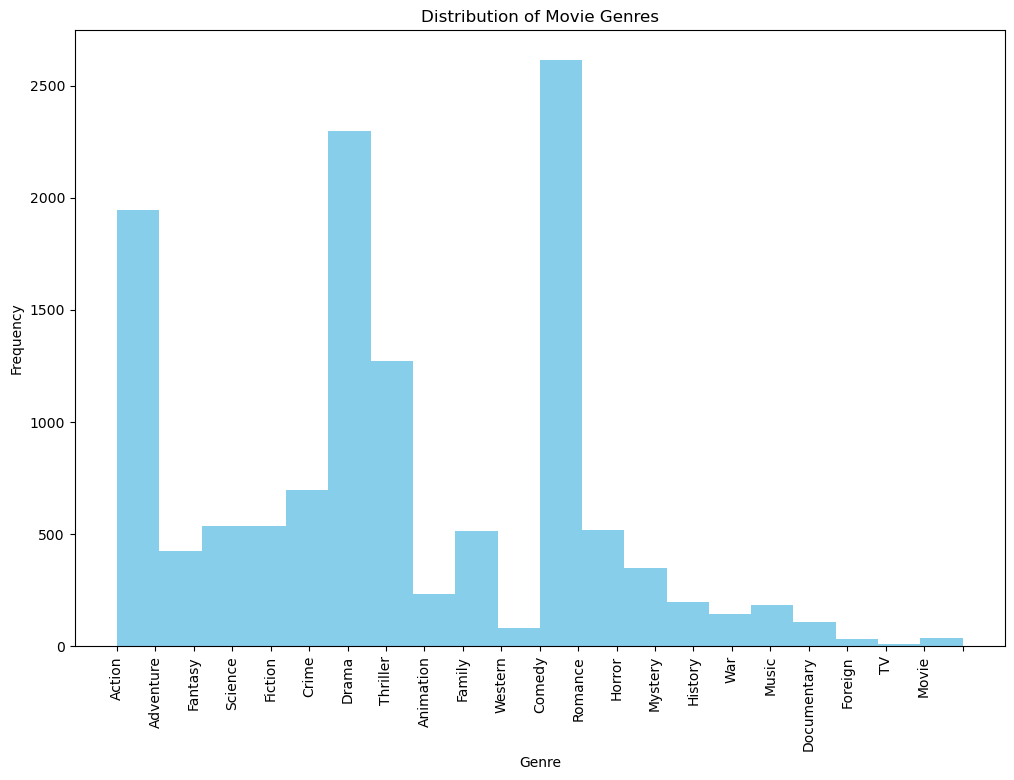

In [38]:
# Example visualization: Distribution of movie genres
movies['genres'] = movies['genres'].str.split(' ')
all_genres = [genre for sublist in movies['genres'] for genre in sublist]
plt.figure(figsize=(12, 8))
plt.hist(all_genres, bins=20, color='skyblue',align = 'mid')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Apply the vectorizer on the combined features
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])
print(tfidf_matrix)

  (0, 7147)	0.11944240653866323
  (0, 16505)	0.11916708568601869
  (0, 6963)	0.12784566767911418
  (0, 602)	0.1035652647188414
  (0, 493)	0.08971093911633833
  (0, 3545)	0.2660484164500814
  (0, 795)	0.20167274822933318
  (0, 14754)	0.25698527425131296
  (0, 13355)	0.24550868729850578
  (0, 7414)	0.2084015827876331
  (0, 19054)	0.2309360211266385
  (0, 12269)	0.17209768042770615
  (0, 19671)	0.2337210823363359
  (0, 13644)	0.28303452737598744
  (0, 12411)	0.26277843072771534
  (0, 5519)	0.2696302805457782
  (0, 11667)	0.24968867216203555
  (0, 13680)	0.3301147732267923
  (0, 3232)	0.19243399296193348
  (0, 225)	0.29567953367045263
  (1, 14969)	0.2704026034453965
  (1, 18376)	0.36646488875339034
  (1, 6188)	0.2683671109526637
  (1, 19418)	0.299320232775134
  (1, 6016)	0.19231228864889158
  :	:
  (4802, 4576)	0.1491677950974323
  (4802, 5633)	0.1068084769658984
  (4802, 10126)	0.1503482843032387
  (4802, 16409)	0.170255762467694
  (4802, 4816)	0.14142405689290616
  (4802, 1311)	0.1675450

In [42]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)
# Create a Series for the movie titles to look up indices easily
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()
indices

[[1.         0.03898534 0.0158045  ... 0.         0.         0.        ]
 [0.03898534 1.         0.01754479 ... 0.02077535 0.         0.        ]
 [0.0158045  0.01754479 1.         ... 0.01447181 0.         0.        ]
 ...
 [0.         0.02077535 0.01447181 ... 1.         0.01958252 0.00686099]
 [0.         0.         0.         ... 0.01958252 1.         0.01170891]
 [0.         0.         0.         ... 0.00686099 0.01170891 1.        ]]


title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

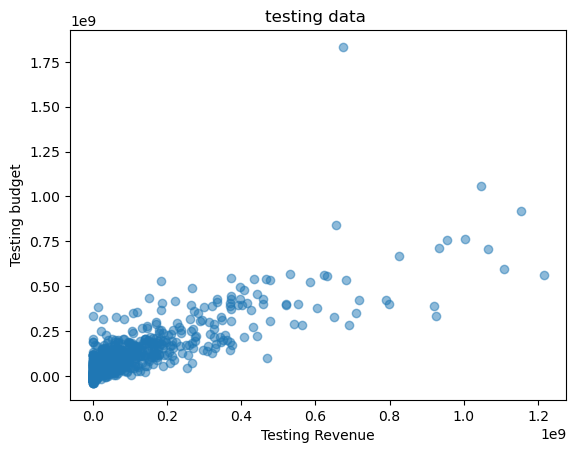

In [43]:
# Prepare data for predicting movie popularity (revenue)
features = movies[['budget', 'popularity', 'runtime']]
target = movies['revenue']

# Handle missing values
features = features.fillna(features.mean())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model

# user_budget = int(input("Enter the budget"))
# user_popular = float(input("Enter the popularity"))
# user_runtime = int(input("Enter the runtime of movie"))
# user = [[user_budget,user_popular,user_runtime]]
y_pred = model.predict(X_test)
# y_pred = model.predict(user)
# print(X_test['budget'])
# print(y_test)
# Plot the results
plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot(y_test,'r')
plt.xlabel('Testing Revenue')
plt.ylabel('Testing budget')
plt.title('testing data ')
plt.show()


In [46]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]  # Get the index of the movie that matches the title
    sim_scores = list(enumerate(cosine_sim[idx]))
    # print(sim_scores)# Get the pairwise similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sort movies
    sim_scores = sim_scores[1:11]  # Get the scores of the 10 most similar movies
    movie_indices = [i[0] for i in sim_scores]  # Get the movie indices
    print(movie_indices)
    return movies['title'].iloc[movie_indices]  # Return the top 10 most similar movies

# Example: Get recommendations for a specific movie
print(get_recommendations('Avatar'))


[3604, 4401, 634, 2130, 1341, 529, 311, 942, 1610, 2628]
3604                       Apollo 18
4401             The Helix... Loaded
634                       The Matrix
2130                    The American
1341            The Inhabited Island
529                 Tears of the Sun
311     The Adventures of Pluto Nash
942                 The Book of Life
1610                           Hanna
2628             Blood and Chocolate
Name: title, dtype: object
